**Fitting the data into the models - Part 2**

Using RandomizedSearchCV as hyperparameter tuning


HYPERPARAMETER TUNING:
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
  splitter: random
  min_samples_split: 2
  min_samples_leaf: 1
  min_impurity_decrease: 0.0
  max_features: sqrt
  max_depth: 5
  criterion: gini
  class_weight: None
  ccp_alpha: 0.0

FEATURE IMPORTANCE:
Occupation_Numeric         0.413714
Daily Steps                0.169930
Gender_Numeric             0.098607
Systolic                   0.077815
BMI_category_numeric       0.075657
Age                        0.072343
Sleep Duration             0.056605
Heart Rate                 0.022533
Stress Level               0.012539
Physical Activity Level    0.000257
dtype: float64

MODEL COMPARISON:

Initial Decision Tree:
(1) Training Accuracy:   0.8763
(2) Test Accuracy:       0.9200
(3) Overfitting (Train - Test): -0.0437

Optimized Decision Tree:
(1) Training Accuracy:   0.9197
(2) Test Accuracy:       0.9600
(3) Overfitting (Train - Test): -0.0403

FINAL MODEL SELECTION:
Best mo

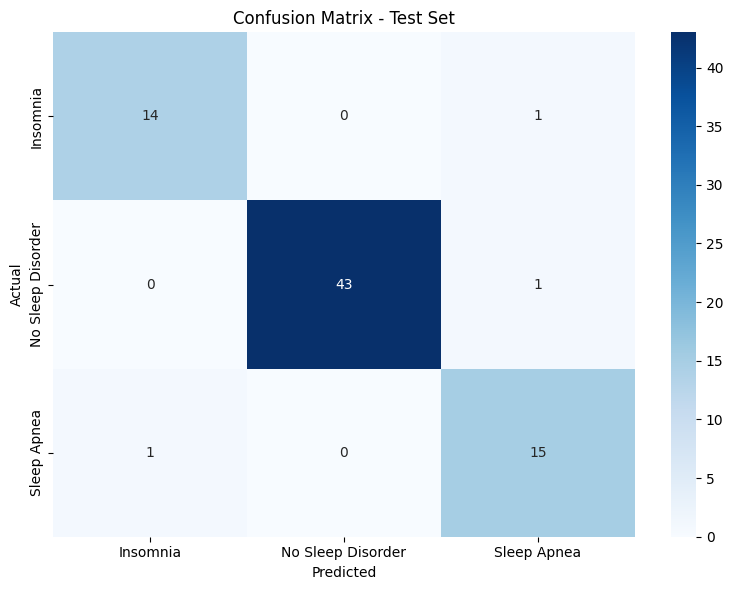

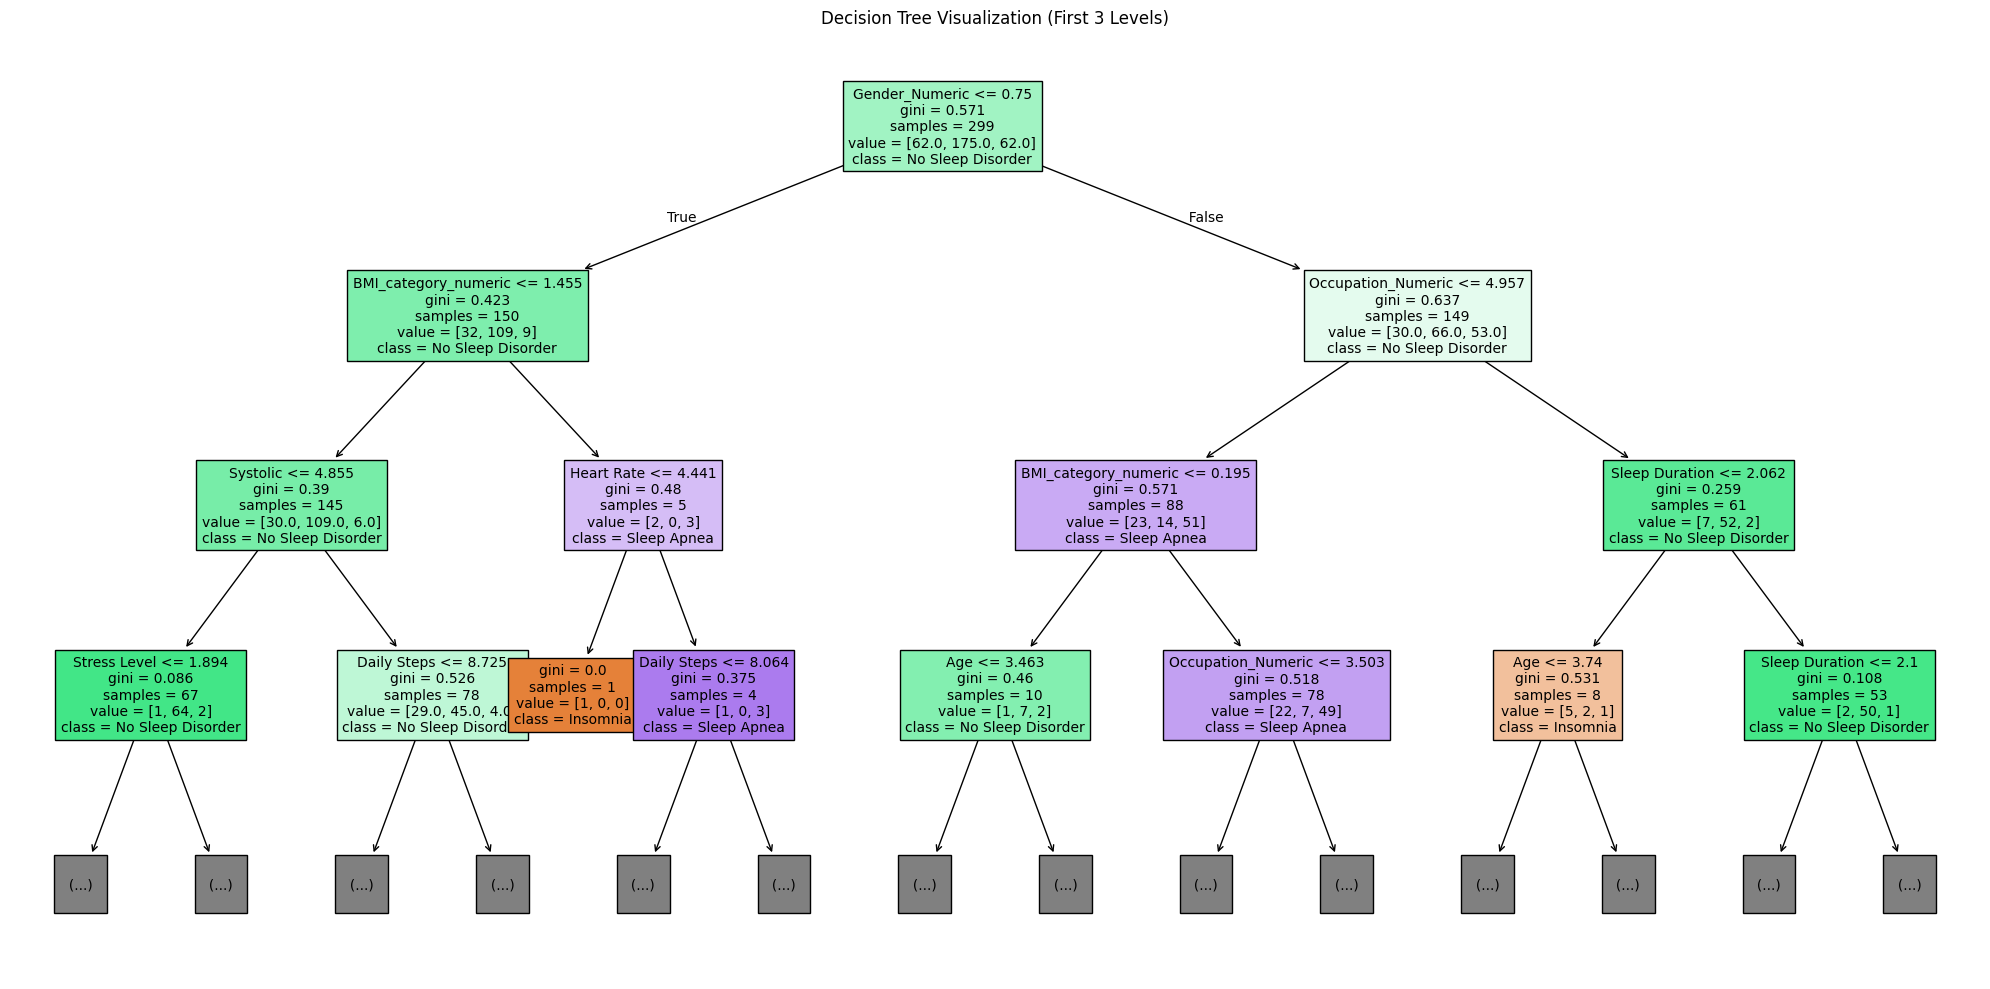

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Load the dataset
df = pd.read_csv('cleaned_data_v2.csv')

# Prepare features and target
X = df.drop('Sleep Disorder', axis=1)
y = df['Sleep Disorder']

# Encode target variable because it is categorical
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ============================================================================
# HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH
# ============================================================================

print("\nHYPERPARAMETER TUNING:")

# Define parameter distribution optimized for small dataset
param_dist = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'splitter': ['best', 'random'],
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.05],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.05],
    'class_weight': [None, 'balanced']  # Added to handle potential class imbalance
}

# Base Decision Tree for comparison
base_dt = DecisionTreeClassifier(random_state=42)

# RandomizedSearchCV with optimized settings
random_search = RandomizedSearchCV(
    base_dt,
    param_dist,
    n_iter=100,  # Reduced for small dataset
    cv=5,        # 5-fold cross-validation (~60 samples per fold)
    scoring='balanced_accuracy',  # Changed to handle potential imbalance
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Get the best model
best_tuned_model = random_search.best_estimator_

# Feature Importance
print("\nFEATURE IMPORTANCE:")
feature_importances = pd.Series(best_tuned_model.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

# Create models for comparison
models = {
    'Initial Decision Tree': DecisionTreeClassifier(
        random_state=42, max_depth=5, min_samples_split=10,
        min_samples_leaf=10, criterion='gini'
    ),
    'Optimized Decision Tree': best_tuned_model
}

# Compare all models
print("\nMODEL COMPARISON:")
model_results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    # Calculate overfitting metric
    overfitting = train_acc - test_acc

    model_results[name] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'overfitting': overfitting,
        'model': model
    }

    print(f"\n{name}:")
    print(f"(1) Training Accuracy:   {train_acc:.4f}")
    print(f"(2) Test Accuracy:       {test_acc:.4f}")
    print(f"(3) Overfitting (Train - Test): {overfitting:.4f}")

# Select the best performing model on test set
best_test_model_name = max(model_results.keys(), key=lambda x: model_results[x]['test_acc'])
best_final_model = model_results[best_test_model_name]['model']

print("\nFINAL MODEL SELECTION:")
print(f"Best model based on test accuracy: {best_test_model_name}")
print(f"Test accuracy: {model_results[best_test_model_name]['test_acc']:.4f}")

# Use the best model for final evaluation
dt_classifier = best_final_model

# Make predictions on train and test sets
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nMODEL PERFORMANCE:")
print(f"(1) Training Accuracy: {train_accuracy:.4f}")
print(f"(2) Test Accuracy: {test_accuracy:.4f}")

# Classification Report for Test Set
print("\nCLASSIFICATION REPORT - TEST SET:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Confusion Matrix for Test Set
print("\nCONFUSION MATRIX - TEST SET:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Visualize the decision tree (first few levels)
plt.figure(figsize=(20, 10))
tree.plot_tree(dt_classifier,
               feature_names=X.columns,
               class_names=le.classes_,
               filled=True,
               max_depth=3,
               fontsize=10)
plt.title('Decision Tree Visualization (First 3 Levels)')
plt.tight_layout()
plt.show()

Analysis of Best Parameters

The best parameters from RandomizedSearchCV are:

1. splitter: random – Uses random splitting instead of evaluating all possible splits at each node, which can reduce overfitting and computation time.

2. min_samples_split: 2 – Allows nodes to split if they contain at least 2 samples, enabling finer-grained splits (default value, less restrictive).

3. min_samples_leaf: 1 – Allows leaves with a single sample, maximizing model flexibility but increasing overfitting risk on a small dataset.

4. min_impurity_decrease: 0.0 – No minimum impurity decrease required for splits, allowing the model to make splits freely (default, less regularization).

5. max_features: sqrt – Considers sqrt(13) ≈ 3-4 features at each split, reducing overfitting by introducing randomness and focusing on key features.

6. max_depth: 5 – Limits tree depth to 5 levels, balancing complexity and generalization for your small dataset (~300 training samples).

7. criterion: gini – Uses Gini impurity for split quality, prioritizing computational efficiency and majority-class splits.

8. class_weight: None – No class weighting, suggesting the model performs well without explicitly balancing the moderately imbalanced classes (44/15/16 in test set).

9. ccp_alpha: 0.0 – No cost-complexity pruning, allowing the tree to grow without additional regularization.
